# Hierarchical Model with common $\sigma^2$ known

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, chi2, f

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
VARIABLE = 'MonthlyIncome'
ALPHA_LEVEL = 0.05

---

Read the data

In [3]:
Dat = pd.read_csv("../../../Data/Processed/DataProvince.csv")
ProvincesProvinceIdRegion = pd.read_csv("../../../Data/Enriched/ProvincesProvinceIdRegion.csv")

In [4]:
Dat = pd.merge(Dat, ProvincesProvinceIdRegion, on='ProvinceId')

In [5]:
Dat['Region'] = Dat['Region'].replace(
    {
        'NorthernThailand': 'Northern Thailand'
        , 'SouthernThailand': 'Southern Thailand'
        , 'WesternThailand': 'Western Thailand'
        , 'EasternThailand': 'Eastern Thailand'
        , 'NortheastThailand': 'Northeast Thailand'
        , 'CentralThailand': 'Central Thailand'
    }
)

Calculate the statistics per region

In [6]:
DatRegion = Dat[[VARIABLE + 'Mean', 'Region']].groupby('Region').agg(['count', 'mean', 'std']).reset_index()

DatRegion.columns = DatRegion.columns.droplevel()

DatRegion = DatRegion.rename(
    columns={
        '':'Region'
        , 'count': 'NumberObservations'
        , 'mean': VARIABLE + 'Mean'
        , 'std': VARIABLE + 'Std'}
    )

DatRegion = DatRegion.sort_values(VARIABLE + 'Mean').reset_index(drop=True)

In [7]:
NDat = DatRegion['NumberObservations'].sum()
J = len(DatRegion)

---

### ANOVA

We perform ANOVA to get punctual estimates for $\mu$, $\sigma^2$ and $\tau^2$.

In [8]:
MeanN = DatRegion['NumberObservations'].mean()

DfW = J * (MeanN-1)
MsW = 1 / (MeanN-1) * (DatRegion[VARIABLE + 'Std']**2 * (DatRegion['NumberObservations']-1)).mean()
HatSigma2Anova = MsW
HatSigmaAnova = np.sqrt(HatSigma2Anova)

DatRegion['BarSigma2Anova'] = HatSigma2Anova / DatRegion['NumberObservations']
HatMuAnova = np.average(DatRegion[VARIABLE + 'Mean'], weights=1 / DatRegion['BarSigma2Anova'])

SsB = (DatRegion['NumberObservations'] * (DatRegion[VARIABLE + 'Mean'] - HatMuAnova)**2).sum()
DfB = J - 1
MsB = SsB / DfB

HatTauAnova = np.sqrt((MsB - MsW) / MeanN)
if np.isnan(HatTauAnova):
    HatTauAnova = 0.01

In [9]:
FStatistic = MsB / MsW
p_value = f.sf(FStatistic, DfB, DfW)
p_value

6.1287553917533885e-06

According to the $p$-value obtained from the $F$ test, we should reject the complete pooling model.

---

### Full Bayes with $\sigma^2$ known ($\sigma^2$ is fixed to its ANOVA estimate)

In this part we perform a full Bayes analysis assuming that $\sigma$ is known, so we can reestimate the previous estimates for $\mu$ and $\tau^2$.

In [10]:
def VMuFunc(tau):
    return 1 / sum(1/(DatRegion['BarSigma2Anova'] + tau**2))

VMuFunc = np.vectorize(VMuFunc)

def HatMuFunc(tau):
    return sum(DatRegion[VARIABLE + 'Mean'] / (DatRegion['BarSigma2Anova'] + tau**2)) * VMuFunc(tau)

HatMuFunc = np.vectorize(HatMuFunc)

def PosteriorTau(tau):

    a = np.log(VMuFunc(tau))
    b = np.sum(np.log(DatRegion['BarSigma2Anova'] + tau**2))
    c = np.sum((DatRegion[VARIABLE + 'Mean'] - HatMuFunc(tau))**2 / (DatRegion['BarSigma2Anova'] + tau**2))

    return np.exp(0.5 * (a - b - c))

PosteriorTau = np.vectorize(PosteriorTau)

def VThetaFuncAux(j, tau):
    DatAux = DatRegion[DatRegion['Region']== j]
    return 1 / (1 / DatAux['BarSigma2Anova'] + 1/tau**2)

VThetaFuncAux = np.vectorize(VThetaFuncAux)

def HatThetaFunc(j, tau):
    DatAux = DatRegion[DatRegion['Region']== j]
    return (DatAux[VARIABLE + 'Mean'] / DatAux['BarSigma2Anova'] + HatMuFunc(tau) / tau**2) * VThetaFuncAux(j, tau)

HatThetaFunc = np.vectorize(HatThetaFunc)

def StdThetaFunc(j, tau):
    return np.sqrt(VThetaFuncAux(j, tau) + 1/tau**4 * VMuFunc(tau) * VThetaFuncAux(j, tau)**2)

StdThetaFunc = np.vectorize(StdThetaFunc)

We get the MAP for $\tau$ and calculate an approx. confidence interval

In [11]:
TauVect = np.linspace(1, 7000, num=100)
PosteriorTauVect = PosteriorTau(TauVect)
HatTauFull = TauVect[np.argmax(PosteriorTauVect)]

NormalizedPosteriorTau =  PosteriorTauVect / PosteriorTau(HatTauFull)

Normalized posterior density of $\tau$

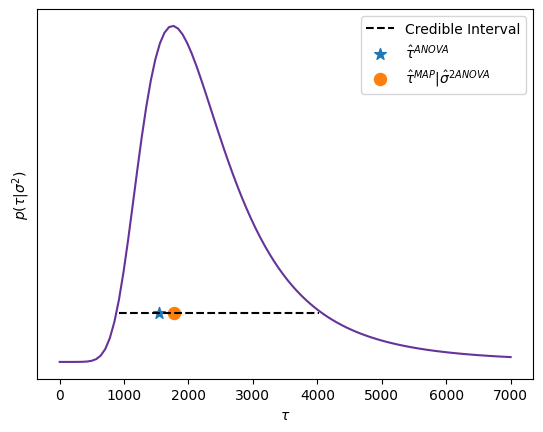

In [12]:
CutLevel = np.exp(-0.5 * chi2.ppf(1-ALPHA_LEVEL, df=1))

LowConfidenceTau = TauVect[NormalizedPosteriorTau > CutLevel][0]
UppConfidenceTau = TauVect[NormalizedPosteriorTau > CutLevel][-1]

plt.plot(TauVect, NormalizedPosteriorTau, color='rebeccapurple')
plt.hlines(CutLevel, LowConfidenceTau, UppConfidenceTau, ls='--', color='k', label='Credible Interval')
plt.scatter(HatTauAnova, CutLevel, marker='*', s=75, label=r'$\hat\tau^{ANOVA}$')
plt.scatter(HatTauFull, CutLevel, marker='o', s=75, label=r'$\hat\tau^{MAP}|\hat\sigma^{2 ANOVA}$')

plt.xlabel(r'$\tau$')
plt.ylabel(r'$p(\tau|\sigma^2)$')
plt.yticks([], [])
plt.legend()

We get a full Bayesian estimate for $\mu$ using $\hat{\mu}$ evaluated in the MAP of $\tau$, and compute a confidence interval.

In [13]:
HatMuFull = HatMuFunc(HatTauFull).reshape(1,)[0]
LowConfidenceMu = HatMuFull - np.sqrt(VMuFunc(HatTauFull)) * norm.ppf(1 - ALPHA_LEVEL / 2)
UppConfidenceMu = HatMuFull + np.sqrt(VMuFunc(HatTauFull)) * norm.ppf(1 - ALPHA_LEVEL / 2)

In [14]:
MuVect = np.linspace(
    LowConfidenceMu - np.sqrt(VMuFunc(HatTauFull))
    , UppConfidenceMu + np.sqrt(VMuFunc(HatTauFull))
    )

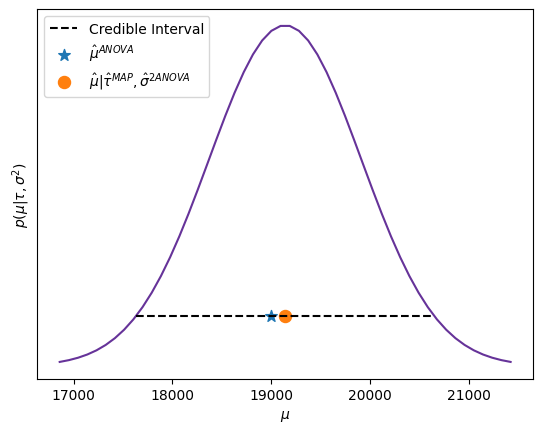

In [15]:
CutLevel = norm.pdf(LowConfidenceMu, loc=HatMuFull, scale=np.sqrt(VMuFunc(HatTauFull)))

plt.plot(MuVect, norm.pdf(MuVect, loc=HatMuFull, scale=np.sqrt(VMuFunc(HatTauFull))), color='rebeccapurple')
plt.hlines(CutLevel, LowConfidenceMu, UppConfidenceMu, ls='--', color='k', label='Credible Interval')
plt.scatter(HatMuAnova, CutLevel, marker='*', s=75, label=r'$\hat\mu^{ANOVA}$')
plt.scatter(HatMuFull, CutLevel, marker='o', s=75, label=r'$\hat\mu|\hat\tau^{MAP},\hat\sigma^{2ANOVA}$')

plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu|\tau,\sigma^2)$')
plt.yticks([], [])
plt.legend(loc='upper left')

This plot is for the conditional posterior means of treatment effects, $E(\theta_j|\sigma,\tau,\mathbf{Y})$.

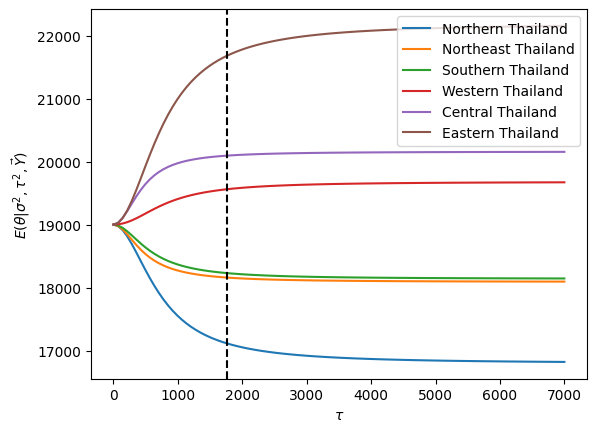

In [16]:
for j in DatRegion['Region']:
    plt.plot(TauVect, HatThetaFunc(j, TauVect), label=j)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$E(\theta|\sigma^2,\tau^2,\vec{Y})$')
plt.legend(loc = 'upper right')

plt.axvline(HatTauFull, ls='--', color='k')

This plot is for the conditional posterior means of treatment effects, $\textsf{Std}(\theta_j|\sigma,\tau,\mathbf{Y})$.

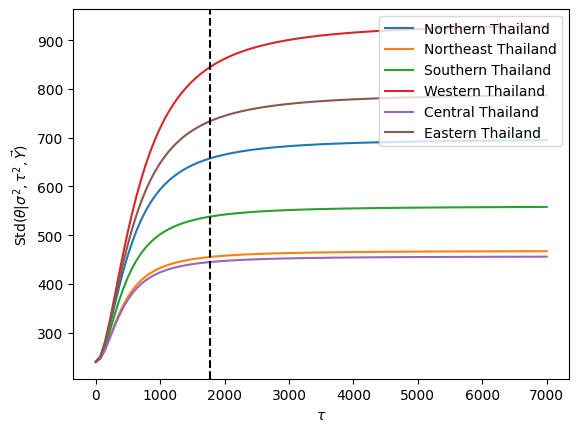

In [17]:
for j in DatRegion['Region']:
    plt.plot(TauVect, StdThetaFunc(j, TauVect), label=j)

plt.xlabel(r'$\tau$')
plt.ylabel(r'Std$(\theta|\sigma^2,\tau^2,\vec{Y})$')
plt.legend(loc = 'upper right')

plt.axvline(HatTauFull, ls='--', color='k')